
  EX 5: MULTI-LAYER PERCEPTRON (MLP) - Banknote Data  

--- Training MLP with Activation: tanh ---
  Accuracy: 0.9636, Precision: 0.9421, F1-Score: 0.9598
  Confusion Matrix:
[[218  11]
 [  4 179]]


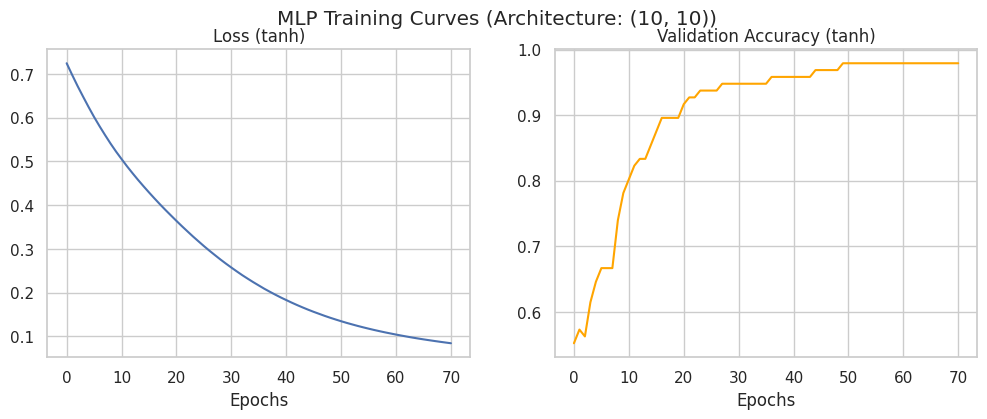


--- Training MLP with Activation: logistic ---


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


  Accuracy: 0.5558, Precision: 0.0000, F1-Score: 0.0000
  Confusion Matrix:
[[229   0]
 [183   0]]


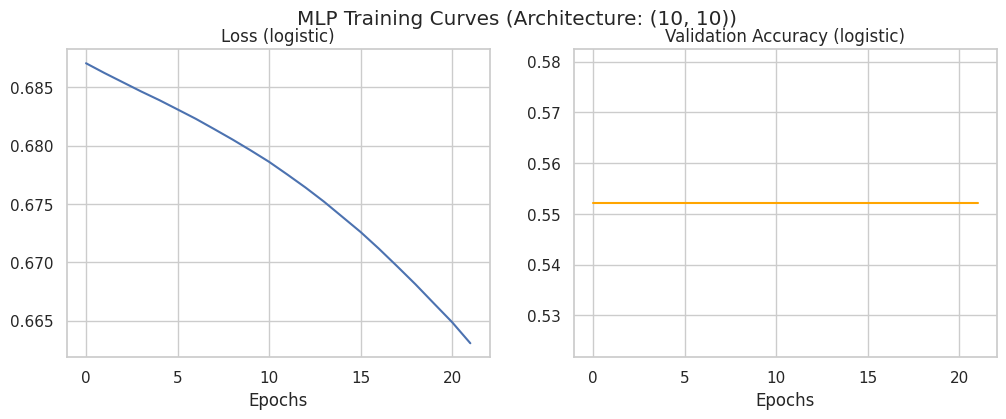


--- Training MLP with Activation: identity ---
  Accuracy: 0.9733, Precision: 0.9433, F1-Score: 0.9708
  Confusion Matrix:
[[218  11]
 [  0 183]]


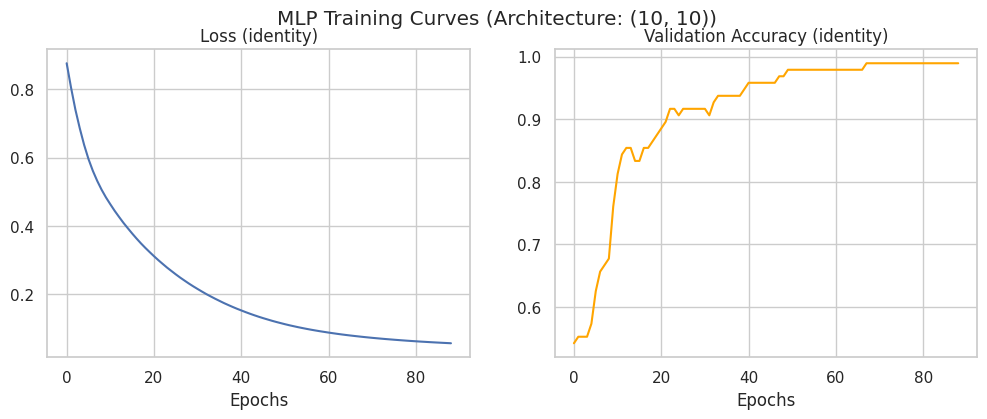


  EX 9: K-MEANS CLUSTERING - Iris Dataset        
Optimal K (by Silhouette Score): 2

Cluster Mapping (Cluster Label vs True Species Count):
True Species   0   1   2
Cluster                 
0              0  50  50
1             50   0   0


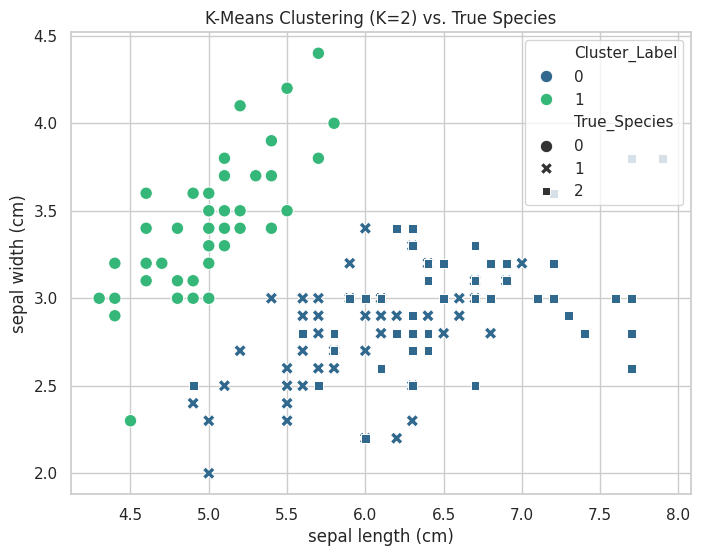


  EX 8b: GRADIENT BOOSTING CLASSIFIER - Breast Cancer  

Gradient Boosting Accuracy: 0.9474
Gradient Boosting ROC AUC: 0.9899

Classification Report:
              precision    recall  f1-score   support

   malignant       0.95      0.91      0.93        64
      benign       0.95      0.97      0.96       107

    accuracy                           0.95       171
   macro avg       0.95      0.94      0.94       171
weighted avg       0.95      0.95      0.95       171



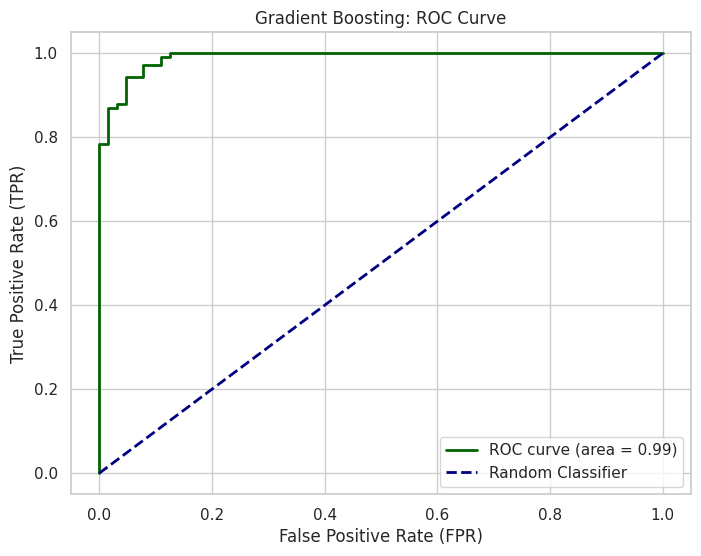

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from io import StringIO
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_recall_fscore_support,
    roc_auc_score, roc_curve, classification_report, silhouette_score
)
from itertools import combinations


RANDOM_STATE = 42
plt.style.use('ggplot')





def run_mlp_banknote():
    print("\n=======================================================")
    print("  EX 5: MULTI-LAYER PERCEPTRON (MLP) - Banknote Data  ")
    print("=======================================================")


    def load_banknote_data():
        data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt"
        try:
            response = requests.get(data_url, timeout=10)
            col_names = ['variance', 'skewness', 'curtosis', 'entropy', 'class']
            return pd.read_csv(StringIO(response.text), header=None, names=col_names)
        except:
            print("Error loading Banknote data. Skipping MLP.")
            return pd.DataFrame()

    data = load_banknote_data()
    if data.empty: return

    X = data.iloc[:, :-1]
    y = data.iloc[:, -1]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y
    )


    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)


    architectures = (10, 10)
    activations = ['tanh', 'logistic', 'identity']
    max_iter = 500

    for activation in activations:
        print(f"\n--- Training MLP with Activation: {activation} ---")

        mlp = MLPClassifier(
            hidden_layer_sizes=architectures,
            activation=activation,
            solver='adam',
            max_iter=max_iter,
            random_state=RANDOM_STATE,
            early_stopping=True,
            validation_fraction=0.1,
            n_iter_no_change=20
        )

        mlp.fit(X_train_scaled, y_train)
        y_pred = mlp.predict(X_test_scaled)


        accuracy = accuracy_score(y_test, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')

        print(f"  Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, F1-Score: {f1:.4f}")
        print(f"  Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}")


        if len(mlp.loss_curve_) > 0:
            fig, ax = plt.subplots(1, 2, figsize=(12, 4))
            ax[0].plot(mlp.loss_curve_, label='Training Loss')
            ax[0].set_title(f'Loss ({activation})')
            ax[0].set_xlabel('Epochs')

            if mlp.validation_scores_ is not None and len(mlp.validation_scores_) > 0:
                ax[1].plot(mlp.validation_scores_, label='Validation Accuracy', color='orange')
                ax[1].set_title(f'Validation Accuracy ({activation})')
                ax[1].set_xlabel('Epochs')

            plt.suptitle(f"MLP Training Curves (Architecture: {architectures})")
            plt.show()




def run_kmeans_iris():
    print("\n===================================================")
    print("  EX 9: K-MEANS CLUSTERING - Iris Dataset        ")
    print("===================================================")

    from sklearn.datasets import load_iris
    iris = load_iris()
    X = pd.DataFrame(iris.data, columns=iris.feature_names)
    y_true = iris.target


    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)


    K_RANGE = range(2, 11)
    silhouette_scores = {}

    for k in K_RANGE:
        kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
        labels = kmeans.fit_predict(X_scaled)
        if k > 1:
            silhouette_scores[k] = silhouette_score(X_scaled, labels)

    if silhouette_scores:
        optimal_k = max(silhouette_scores, key=silhouette_scores.get)
        print(f"Optimal K (by Silhouette Score): {optimal_k}")
    else:
        optimal_k = 3


    final_kmeans = KMeans(n_clusters=optimal_k, random_state=RANDOM_STATE, n_init=10)
    final_clusters = final_kmeans.fit_predict(X_scaled)


    results_df = X.copy()
    results_df['Cluster_Label'] = final_clusters
    results_df['True_Species'] = y_true

    print("\nCluster Mapping (Cluster Label vs True Species Count):")
    print(pd.crosstab(results_df['Cluster_Label'], results_df['True_Species'], rownames=['Cluster'], colnames=['True Species']))


    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        x=X.columns[0],
        y=X.columns[1],
        hue='Cluster_Label',
        style='True_Species',
        data=results_df,
        palette='viridis',
        s=80
    )
    plt.title(f'K-Means Clustering (K={optimal_k}) vs. True Species')
    plt.show()





def run_gradient_boosting():
    print("\n========================================================")
    print("  EX 8b: GRADIENT BOOSTING CLASSIFIER - Breast Cancer  ")
    print("========================================================")

    from sklearn.datasets import load_breast_cancer
    data = load_breast_cancer()
    X = data.data
    y = data.target
    target_names = data.target_names

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y
    )


    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)


    gb_clf = GradientBoostingClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        random_state=RANDOM_STATE
    )

    gb_clf.fit(X_train_scaled, y_train)
    y_pred = gb_clf.predict(X_test_scaled)
    y_pred_proba = gb_clf.predict_proba(X_test_scaled)[:, 1]


    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    print(f"\nGradient Boosting Accuracy: {accuracy:.4f}")
    print(f"Gradient Boosting ROC AUC: {roc_auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=target_names))


    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkgreen', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
    plt.title('Gradient Boosting: ROC Curve')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.legend(loc="lower right")
    plt.show()




if __name__ == '__main__':

    try:
        import seaborn as sns
        sns.set_theme(style="whitegrid")
    except ImportError:
        pass

    run_mlp_banknote()
    run_kmeans_iris()
    run_gradient_boosting()